# Percolation study on $10\times 10$ nm MAC at $T = 300$ K.

The purpose of this notebook is to test abd illustrate my code for finding spanning clusters of MOs in a snapshot of a MAC fragment during a $NVT$ MD simulation ran at $T = 300K$ .
Here, we are using the 800000th frame corresponding to $t = 40$ ps.

## Step 1: Loading the QCFFPI data

First, we read the data from the QCFFPI output files containing the MO matrix $M_{ij} = \langle\varphi_i | \psi_j\rangle$ and the MO energies $\varepsilon_j = \langle\psi_j|H|\psi_j\rangle$.

In [1]:
from os import path
from time import perf_counter
from qcnico.qcffpi_io import read_energies, read_MO_file

datadir = path.expanduser('~/Desktop/simulation_outputs/qcffpi_data/MO_dynamics/300K_initplanar_norotate/')
energy_dir = 'orbital_energies'
mo_dir = 'MO_coefs'

frame_nb = 80000
mo_file = f'MOs_frame-{frame_nb}.dat'
energy_file = f'orb_energy_frame-{frame_nb}.dat'

mo_path = path.join(datadir,mo_dir,mo_file)
energy_path = path.join(datadir,energy_dir,energy_file)

energies = read_energies(energy_path)
pos, M = read_MO_file(mo_path)

## Step 2: MO characteristics of our MAC fragment

Now that we have all of the quantum mechanical data extracted from our QCFFPI data files, let's check out the properties of this MAC fragment:

* how strongly strongly coupled are its MOs to the left and right electrodes?

* what do the most highly coupled MOs look like?

* what are the localisation characteristics of the fragment's MOs (e.g. do they exhibit torn localisation?)?

This will help guide our intuition and will allow us to set adequate criteria for when cluster of MOs can considered to span the whole fragment.

### Step 2a: MO-lead couplings.

First, we plot the relation between the energies and the coupling to the leads of each MO, where for MO $\psi_j\rangle$, the coupling to lead $\alpha$ is given by $\langle\psi_j|\Gamma_{\alpha}|\psi_j\rangle$ (for $\alpha\in\{L,R\}$).

Fermi energy of fragment = -0.353427755 eV
Bandwidth of fragment = 0.55757685 eV


/Users/nico/Desktop/scripts/qcnico/qcnico/find_edge_carbons.py:99: RuntimeWarning: invalid value encountered in true_divide
  angles = np.arccos((vs @ u)/(norm_vs*norm_u))


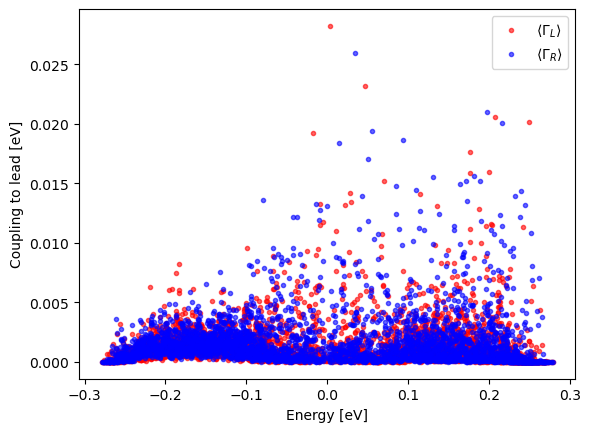

In [2]:
import qcnico.qchemMAC as qcm
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['image.aspect'] = 'auto'

N = M.shape[0]
eF = 0.5 * ( energies[N//2] + energies[(N//2)-1] )

print(f'Fermi energy of fragment = {eF} eV')
print(f'Bandwidth of fragment = {energies[-1] - energies[0]} eV')

energies -= eF #center energies around eF occupied MOs have E<0 and unoccupied MOs have E>0

ga = 0.1 #edge atome-leaf coupling in eV
agaL, agaR = qcm.AO_gammas(pos,ga)
gamL, gamR = qcm.MO_gammas(M,agaL, agaR, return_diag=True)

plt.plot(energies, gamL, 'r.', label='$\langle\Gamma_L\\rangle$', alpha=0.6)
plt.plot(energies, gamR, 'b.', label='$\langle\Gamma_R\\rangle$', alpha=0.6)
plt.xlabel('Energy [eV]')
plt.ylabel('Coupling to lead [eV]')
plt.legend()
plt.show()



This is pretty noisy, but the most strongly coupled MOs are close to the Fermi energy (as expected). 

Now let's check the distribution of these MO-lead couplings.

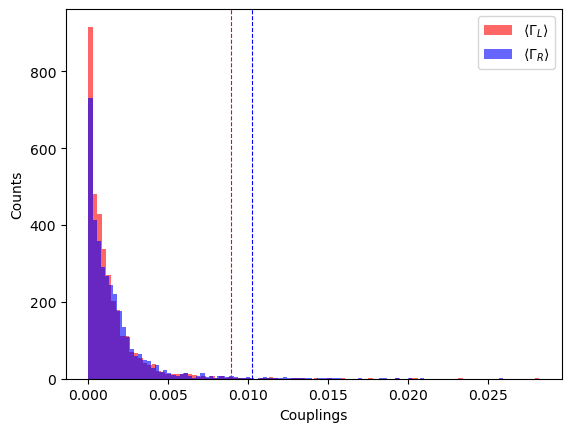

In [3]:
import numpy as np
import qcnico.plt_utils as plt_utils

plt_utils.histogram(gamL,nbins=100,xlabel='Couplings',show=False, normalised=False,
    plt_kwargs={'alpha': 0.6, 'color': 'r', 'label': '$\langle\Gamma_L\\rangle$'})
plt_utils.histogram(gamR,nbins=100,show=False, normalised=False,
    plt_kwargs={'alpha': 0.6, 'color': 'b', 'label': '$\langle\Gamma_R\\rangle$'})
plt.legend()
plt.axvline(x=np.mean(gamL) + 4*np.std(gamL), ymin=0, ymax=1, color='r', ls='--',lw=0.8)
plt.axvline(x=np.mean(gamR) + 4*np.std(gamR), ymin=0, ymax=1, color='b', ls='--',lw=0.8)
plt.show()


### Step 2b: Examining the morphology of the most strongly coupled MOs

OK, so it seems that very few MOs have couplings stronger than $\gamma_m = 0.01$ eV. We therefore set $\gamma_m$ to be the threshold for what we consider to be 'strong coupling. Let's examine what these strongly coupled MOs look like, and if any of them exhibit high values of both $\langle\Gamma_L\rangle$ and $\langle\Gamma_R\rangle$.

There are 27 MOs strongly coupled to the left electrode. 
There are 47 MOs strongly coupled to the right electrode. 


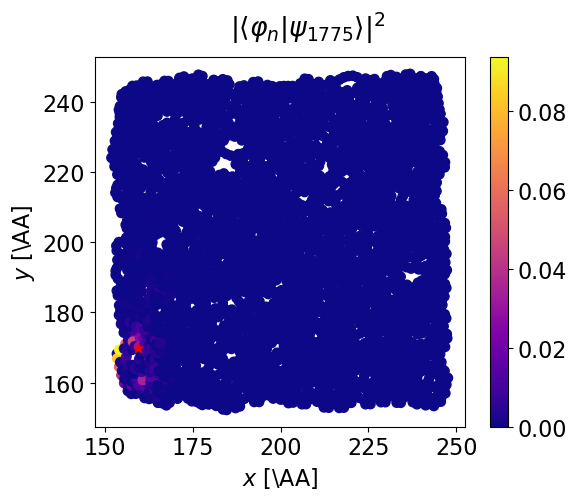

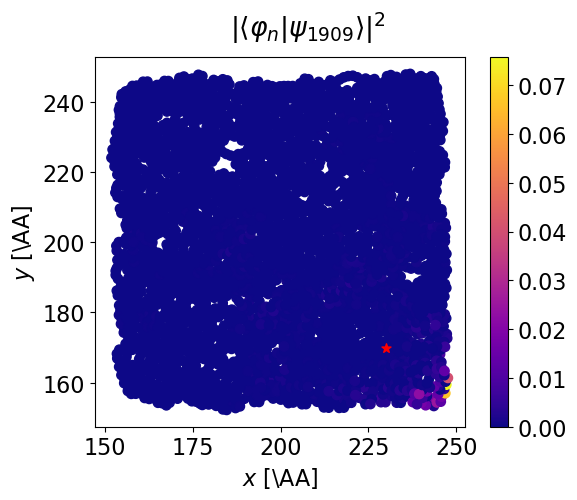

In [4]:
from qcnico.mo_plotting import plot_MO

gammam = 0.01

biggaL_inds = (gamL > gammam).nonzero()[0]
biggaR_inds = (gamR > gammam).nonzero()[0]

print(f'There are {biggaL_inds.shape[0]} MOs strongly coupled to the left electrode. ')
print(f'There are {biggaR_inds.shape[0]} MOs strongly coupled to the right electrode. ')

jL = gamL.argmax() #index of MO max coupled to the left lead
jR = gamR.argmax() #index of MO max coupled to the right lead

plot_MO(pos, M, jL, show_COM=True,usetex=False)

plot_MO(pos,M,jR,show_COM=True,usetex=False)

